# OPTIMIZATION FOR LARGE-SCALE DATA

Non-linear Optimization

Francisco Esteves Muñoz

Date: 12/01/2023

# Introduction

Generate random data from a predefined linear regression model where $-5\leq\beta_{j}\leq 5 $ $j=0,1,...,K$ with at least K = 100 independent variables $X =$ $(X_{1},X_{2}, ... ,X_{K})$ and n = 1000 observations. We seek to adjust a multiple linear regression model to explain variable Y as a function of the other variables X, i.e., $(Y = X\beta + \epsilon)$ where $\beta = (\beta_{0},\beta_{1},...,\beta_{k})^{T}$ , by using a
fourth-order regularization method:

$$ min_{\beta}: 1/n \sum\limits_{i} (y_{i}-x_{i}\beta)^{2} + \rho\sum\limits_{j} \beta_{j}^{4}  $$

where $\rho$ is a parameter (consider it fixed to a given value, e.g., $\rho = 1$).


First, the betas will be aleatory generated using a Beta distribution. The coefficients to be used are $\alpha=2$ and $\beta=2$, given a dymetric distrbution arrownd (0,1),latter, that distrbution will be transformed into the interval (-5,5) obtaining a zero-centered distribution of betas. This assignment will be done with 100 $\beta's$.

In [ ]:
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

In [ ]:
a = 2       # Alpha parameter
b = 2       # Beta parameter
K = 100     # Number of parameters
np.random.seed(12345)       # Setting seed for reproducibility
betas = (np.random.beta(a, b, size=K)-0.5)*10     # Calling the random function and then scaling those parameters

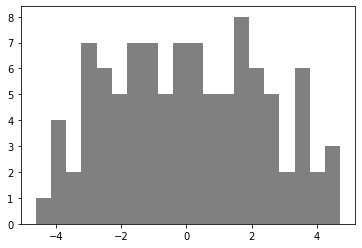

Maximum beta:  4.711989626656
Minimum beta:  -4.61747448837473


In [ ]:
# Show the histogram
plt.hist(betas, bins=20,color='Grey', label='Histogram of parameter betas')
plt.show()

# Show that the betas are in the (-5,5) range:
print('Maximum beta: ', max(betas))
print('Minimum beta: ', min(betas))

Later, the final output variable will be defined. For doing this, the $\epsilon$ error will be defined as the Gaussian $N(0,1)$, the observations $X_{k}$ are generated and then the output will be generated as $Y = X\beta + \epsilon$.

In [ ]:
import math

The observations will all be generated using the Gaussian distribution, but different means and deviation will be used for each variable. Note that it is important to scale all the observations when doing a Lasso shrikage regression problem. That is why all the observation will have zero mean and one standard deviation.

In [ ]:
n = 1000        # Setting the number of observations
sigma_err = 1   # Setting the intrinsec error of the model

epsilon = np.random.normal(loc=0.0, scale=math.sqrt(sigma_err), size=(n,))   # Vector of errors with zero mean
betas = np.reshape(betas,(K,))

# Defininf the observations matrix:
X = np.random.normal(loc=0.0, scale=1.0, size=(n,K))

Notice that the X matrix of observation does not have a column of ones in the first column, as all the variables have been scaled (zero mean and constant standard deviation), the term $\beta_{0}$ is not needed.

#A. Minimize the error
Estimate the value of the regression coeffcients by using the function minimize
from the Python module Scipy.optimize. Try at least four available solvers and compare their performance in terms of number of iterations, number of function, gradient and hessian evaluations as well as total computational time.

In [ ]:
import scipy as sp
import scipy.optimize as opt
from time import time

First, define the response variable of the regression:

In [ ]:
y = X@betas + epsilon
rho = 1

Later, the key part is to define correcly the error function to minimize, aswell as the gradient and Hessian.
### Error function

The error function is as it has been described before:

$$ min_{\beta}\frac{1}n||y-X\beta||_{2}^2+\rho||\beta^{4}||_{1}$$

In the function, it will be written in vectorized form:

$$ min_{\beta}\frac{1}n(y-X\beta)^T(y-X\beta)+\rho(\beta^{.2})^T\beta^{.2}$$

Where the $".2"$ implies to apply the sqared to every element, not changing the shape of the vector.

In [ ]:
def error(betas_try, rho , X , y ):
  # Defining the error as a sum between the error of the least squares and the Lasso regularization:
  n = X.shape[0]
  error = 1/n*((y - X@betas_try).T) @ (y - X@betas_try) + rho*((betas_try**2).T) @ (betas_try**2)

  return error

### Jacobian

The jacobian is obtain taking parcial derivatives of the cost function:

$$\triangledown f = -\frac{2}nX^T(y - X\beta) + 4\rho\beta^{.3}$$

In [ ]:
def jacob(betas_try, rho , X , y ):

  n = X.shape[0]
  jacob = -2/n*((X.T)@(y-X@betas_try)) + 4*rho*(betas_try**3)

  return jacob

### Hessian
The Hessian for the least squares problem with the modified Lasso y set as follows:

$$\triangledown^2 f = \frac{2}nX^TX + \rho B$$
$$B=\left\{\begin{array}{ll}
12\rho\beta_{i}^2 & \textrm{if $i=j$}\\
0 & \textrm{otherwise}
\end{array}\right.$$

In [ ]:
def hess(betas_try, rho , X , y ):
  n = X.shape[0]
  hess = 2/n*(X.T)@X
  for k in range(K):
    hess[k,k]+= 12*rho*betas_try[k]**2

  return hess

Finally, the initial vector of $\beta $s will be setted. The zero vector will be the starting point of every algorithm.

In [ ]:
beta0 = np.zeros((K,))

### A.1 Optimization using Powell

The first solver optimization method to be used is Powel, this is one of the simpler ones presented by the library. This method calculates the derivatives with the proper function in order to converge. This set up is what makes it the lowest of all the four trials.

In [ ]:
t1 = time()   # Initialize time

# For Powel, no jacobian nor hessian is passed to the function.
beta_sol_P = opt.minimize(error,
                          beta0,
                          args=(rho,X,y),
                          method='Powell',
                          options={'disp': True})
t2 = time()   # Finish time
ex_time_P = t2-t1

# Lastly, the mean of squared errors will be calculated for the beta soluttion:

err_P = 1/K*((betas-beta_sol_P.x).T)@(betas-beta_sol_P.x)

# Print some results:
print('Execution time: ',ex_time_P)
print('Mean squared error for the sollution: ', err_P)

Optimization terminated successfully.
         Current function value: 276.397006
         Iterations: 3
         Function evaluations: 3424
Execution time:  0.41254568099975586
Mean squared error for the sollution:  2.5159350599823003


It can be seen that the mean squared error is considerably large, most of all, considering the real distribution of the $\beta s$. However, this error is induced by the large bias introduced in the $\rho$ term, which is large for this distrbution of $\beta s$.

One particular aspect to note about this method is the small number of iterations used to converge, but the large number of function evaluations. Excecution time is rather high comparing to other methods.

### A.2 Optimization using CG

Second solver used is the CG method, again, the jacobian is setted to the minimizer but not the hessian.

In [ ]:
t1 = time()   # Initialize time

# For CG, jacobian is passed to the function but the hessian is not.
beta_sol_CG = opt.minimize(error,
                          beta0,
                          args=(rho,X,y),
                          method='CG',
                          jac=jacob,
                          options={'disp': True})
t2 = time()   # Finish time
ex_time_CG = t2-t1

# Lastly, the mean of squared errors will be calculated for the beta soluttion:

err_CG = 1/K*((betas-beta_sol_CG.x).T)@(betas-beta_sol_CG.x)

# Print some results:
print('Execution time: ',ex_time_CG)
print('Mean squared error for the sollution: ', err_CG)

Optimization terminated successfully.
         Current function value: 276.396994
         Iterations: 22
         Function evaluations: 48
         Gradient evaluations: 48
Execution time:  0.025730371475219727
Mean squared error for the sollution:  2.5158739228791274


The execution time is the lowest of all the methods and the number of iterations is average. It is noted that around 2 evaluations of the gradient and the function per iteration.

### A.3 BFGS

In [ ]:
t1 = time()   # Initialize time

# For BFGS, jacobian is passed to the function but the hessian is not.
beta_sol_BFGS = opt.minimize(error,
                          beta0,
                          args=(rho,X,y),
                          method='BFGS',
                          jac=jacob,
                          options={'disp': True})
t2 = time()   # Finish time
ex_time_BFGS = t2-t1

# Lastly, the mean of squared errors will be calculated for the beta soluttion:

err_BFGS = 1/K*((betas-beta_sol_BFGS.x).T)@(betas-beta_sol_BFGS.x)

# Print some results:
print('Execution time: ',ex_time_BFGS)
print('Mean squared error for the sollution: ', err_BFGS)

Optimization terminated successfully.
         Current function value: 276.396994
         Iterations: 31
         Function evaluations: 58
         Gradient evaluations: 58
Execution time:  0.048363685607910156
Mean squared error for the sollution:  2.5158740140445883


This method gives similar results as CG in terms of iterations and evaluations. However, the execution time is 3 times higher.

### A.4 Optimizing using Newton CG

The last solver used, is Newton CG, the same algorithm used in section A.2 but this time, hessian is used in order to set the step vector direction, which makes it to converge in less iterations.

In [ ]:
t1 = time()   # Initialize time

# For NCG both jacobian and hessian are passed to the function.
beta_sol_NCG = opt.minimize(error,
                          beta0,
                          args=(rho,X,y),
                          method='Newton-CG',
                          jac=jacob,
                          hess=hess,
                          options={'disp': True})
t2 = time()   # Finish time
ex_time_NCG = t2-t1

# Lastly, the mean of squared errors will be calculated for the beta soluttion:

err_NCG = 1/K*((betas-beta_sol_NCG.x).T)@(betas-beta_sol_NCG.x)

# Print some results:
print('Execution time: ',ex_time_NCG)
print('Mean squared error for the sollution: ', err_NCG)

Optimization terminated successfully.
         Current function value: 276.396994
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14
         Hessian evaluations: 12
Execution time:  0.03612780570983887
Mean squared error for the sollution:  2.515874047851025


For this part of the assignment, it is clear that all those four algorithms have reached to an optimal sollution for the Lasso problem. Note that all algorithms gives similar results to the function value and mean squared error between the true $\beta$ and the solution found.

The mean squared error remaining is due to the intrinsec bias impossed by shrinkage and by the $\epsilon$ error also (uncertanty).


Taking into consideration the execution time, the best solver is 'CG', however, when considering the number of iterations, 'Newton-CG' performs the method in less iterations (but more complicated).

The solution is printed below, using the Newton CG:

In [ ]:
print('Solution for the shrinkage least squares problem:')
index = ['beta '+str(i) for i in range(1,K+1)]
data = pd.DataFrame(beta_sol_NCG.x, index=index,columns=["Coefficents"])
data

Solution for the shrinkage least squares problem:


,Coefficents
beta 1,-0.842674
beta 2,0.752988
beta 3,0.534523
beta 4,-1.126429
beta 5,0.773185
...,...
beta 96,0.931759
beta 97,-0.166417
beta 98,0.413599
beta 99,-0.738729


# C. Algorithms implementation
Estimate the value of the regression coecients by implementing the:

  i. (1.5 points) Gradient method.

  ii. (1.5 points) Newton method.

  iii. (1 points) Quasi-Newton method.

Consider a line search technique to improve the algorithm convergence, e.x., Armijo rule.Compare the performance of these algorithms (number of iterations and total computa-tional time).

For the following algorithms, the armijo rule will be setting the $\alpha$ (step length) for every iteration. The condition to be fulfilled is the followign:

$$ f(x_k + \alpha p_k) \leq f(x_k) + \sigma \alpha p_k^T \triangledown f(x_k) $$

while setting:

$\sigma = 10^{-3}$

$\beta = 0.20$

trying $\alpha$ to be $s=1.0$

$\alpha = s\beta$,    $\alpha = s\beta^2$, $\alpha = s\beta^3$,...
being $\alpha$ the first one to fulfill the previous equation.

### C.1 Gradient method

In [ ]:
from pyparsing.helpers import alphas
# Definition of the gradient function:
def gradient_desc(func, jacob, x0, maxiter, tolerance, s, beta, sigma):
  iter = 0
  past = x0+tolerance*1e6
  current = x0
  K = x0.size
  err_list = []
  alpha_list = []
  while math.sqrt(((current-past).T @ (current-past)))/K>tolerance and iter<=maxiter:
    iter += 1
    past = current
    p = -jacob(current,rho,X,y)

    # Inducing the armijo rule to find alpha:
    alpha = s
    while (error(current+alpha*p,rho,X,y) > error(current,rho,X,y) + sigma*alpha*p.T@jacob(current,rho,X,y)):
      alpha = alpha*beta
    alpha_list.append(alpha)
    # Once the alpha is sett, perform the descent:
    current = current + alpha*p
    err_list.append(error(current,rho,X,y))

  sol = current
  func_val = func(current,rho,X,y)
  return sol, func_val, iter, err_list, alpha_list

In [ ]:
# Implementation of the method:
tol = 1e-8
# Armijo inputs
s = 1
beta = 0.2
sigma = 1e-3

maxiter = 1e5
t1 = time()
sol_GD, func_val_GD, iter_GD,err_list_GD, alpha_list_GD = gradient_desc(error,jacob,beta0,maxiter,tol,s,beta,sigma)
t2 = time()

err_GD = 1/K*((betas-sol_GD).T)@(betas-sol_GD)
ex_time_GD = t2-t1

Execution time:  0.12273383140563965
Function value at solution:  276.3969935554289
Number of iterations:  54
Mean squared error for the sollution:  2.5158740018524655 



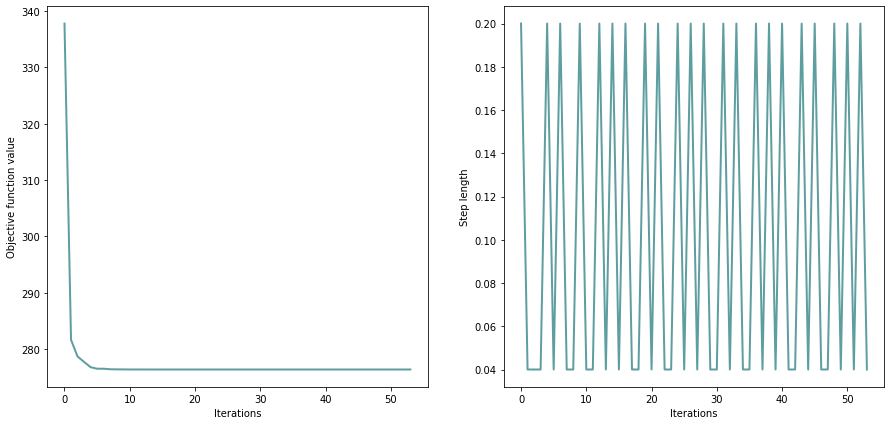

In [ ]:
# Print some results:
print('Execution time: ',ex_time_GD)
print('Function value at solution: ', func_val_GD)
print('Number of iterations: ', iter_GD)
print('Mean squared error for the sollution: ', err_GD,'\n')

# Plot

fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(15,7))

axs[0].plot([i for i in range(len(err_list_GD))],err_list_GD,color='cadetblue',linewidth=2)
axs[0].set_ylabel('Objective function value')
axs[0].set_xlabel('Iterations');

axs[1].plot([i for i in range(len(alpha_list_GD))],alpha_list_GD,color='cadetblue',linewidth=2)
axs[1].set_ylabel('Step length')
axs[1].set_xlabel('Iterations');

The gradient descent method gives similar results to the scipy solvers in terms of iterations and execution time. The mean squared error and objective function value gives same results. Particularly, in the graph we can see that the gradient descent converge into a resonably well solution before the 10th iteration, but struggles to fitt into the tolerance setted of $10^{-8}$.

### C.2 Newton method

In [ ]:
# Definition of the gradient function:
def newt(func, jacob, hess, x0, maxiter, tolerance,  s, beta, sigma):
  iter = 0
  past = x0+tolerance*1e6
  current = x0
  K = x0.size
  err_list = []
  alpha_list = []
  while math.sqrt(((current-past).T @ (current-past)))/K>tolerance and iter<=maxiter:
    iter += 1
    past = current
    H = hess(current,rho,X,y)            # Calculating the hessian at the current point x*
    Hinv = np.linalg.inv(H)       # Inverting the KxK matrix
    p = - Hinv@jacob(current,rho,X,y)      # Step direction for updating

    # Inducing the armijo rule to find alpha:
    alpha = s
    while error(current+alpha*p,rho,X,y) > error(current,rho,X,y) + sigma*alpha*p.T@jacob(current,rho,X,y):
      alpha = alpha*beta
    alpha_list.append(alpha)
    # Once the alpha is sett, perform the descent:

    current = current + alpha*p   # Modified the gradient descent with the Hessian aswell
    err_list.append(error(current,rho,X,y))

  sol = current
  func_val = func(current,rho,X,y)
  return sol, func_val, iter, err_list, alpha_list

In [ ]:
# Implementation of the method:
tol = 1e-8
# Armijo inputs
s = 1
beta = 0.2
sigma = 1e-3

maxiter = 1e5
t1 = time()
sol_N, func_val_N, iter_N, err_list_N, alpha_list_N = newt(error,jacob,hess,beta0,maxiter,tol,s,beta,sigma)
t2 = time()

err_N = 1/K*((betas-sol_N).T)@(betas-sol_N)
ex_time_N = t2-t1

Execution time:  0.029719114303588867
Function value at solution:  276.3969935554197
Number of iterations:  8
Mean squared error for the sollution:  2.5158738089473216 



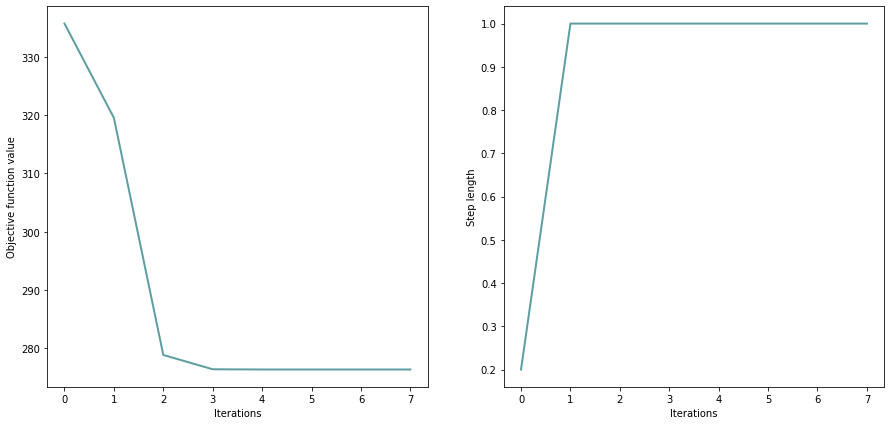

In [ ]:
# Print some results:
print('Execution time: ',ex_time_N)
print('Function value at solution: ', func_val_N)
print('Number of iterations: ', iter_N)
print('Mean squared error for the sollution: ', err_N,'\n')

# Plot

fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(15,7))

axs[0].plot([i for i in range(len(err_list_N))],err_list_N,color='cadetblue',linewidth=2)
axs[0].set_ylabel('Objective function value')
axs[0].set_xlabel('Iterations');

axs[1].plot([i for i in range(len(alpha_list_N))],alpha_list_N,color='cadetblue',linewidth=2)
axs[1].set_ylabel('Step length')
axs[1].set_xlabel('Iterations');

Newton method gives excelent results, less than half the execution time of the scipy solver and very few iterations performed to acomplish that.

Altough higher performance iterations are used for Newton, the final convergence (at the last iterations) is performed much faster for the same tolerance.

### C.3 Quasi-Newton method
The quasi-Newton method to implement will be the BFGS. This is used at every actualization of the hessian aproximation.

In [ ]:
# Definition of the gradient function:
def quas_newt(func, jacob, hess, x0, maxiter, tolerance,  s, beta, sigma):
  iter = 0
  past = x0+tolerance*1e6
  current = x0
  K = x0.size
  err_list = []
  alpha_list = []
  while math.sqrt(((current-past).T @ (current-past)))/K>tolerance and iter<=maxiter:
    iter += 1

    if iter == 1:
      B = hess(current,rho,X,y)    # At the first iteration, the matrix B is the hessian
    else:                   # Aproximation of the hessian matrix
      x_dif = current - past
      y_dif = jacob(current,rho,X,y)-jacob(past,rho,X,y)

      M2 = ((B @ x_dif)@(B @ x_dif).T)/(x_dif.T @ B @ x_dif)
      M3 = y_dif @ y_dif.T/(y_dif.T @ x_dif)

      B = B - M2 + M3

    Binv = np.linalg.inv(B)       # Inverting the KxK matrix
    p = - Binv@jacob(current,rho,X,y)    # Step direction for updating

    # Inducing the armijo rule to find alpha:
    alpha = s
    while error(current+alpha*p,rho,X,y) > error(current,rho,X,y) + sigma*alpha*p.T@jacob(current,rho,X,y):
      alpha = alpha*beta
    alpha_list.append(alpha)
    # Once the alpha is sett, perform the descent:
    past = current
    current = current + alpha*p   # Modified the gradient descent with the Hessian aproximation aswell
    err_list.append(error(current,rho,X,y))

  sol = current
  func_val = func(current,rho,X,y)
  return sol, func_val, iter, err_list, alpha_list

In [ ]:
# Implementation of the method:
tol = 1e-8
# Armijo inputs
s = 1
beta = 0.2
sigma = 1e-3

maxiter = 1e5
t1 = time()
sol_QN, func_val_QN, iter_QN, err_list_QN, alpha_list_QN = quas_newt(error,jacob,hess,beta0,maxiter,tol,s,beta,sigma)
t2 = time()

err_QN = 1/K*((betas-sol_QN).T)@(betas-sol_QN)
ex_time_QN = t2-t1

Execution time:  0.13515210151672363
Function value at solution:  276.41135998063123
Number of iterations:  86
Mean squared error for the sollution:  2.5159780267723377 



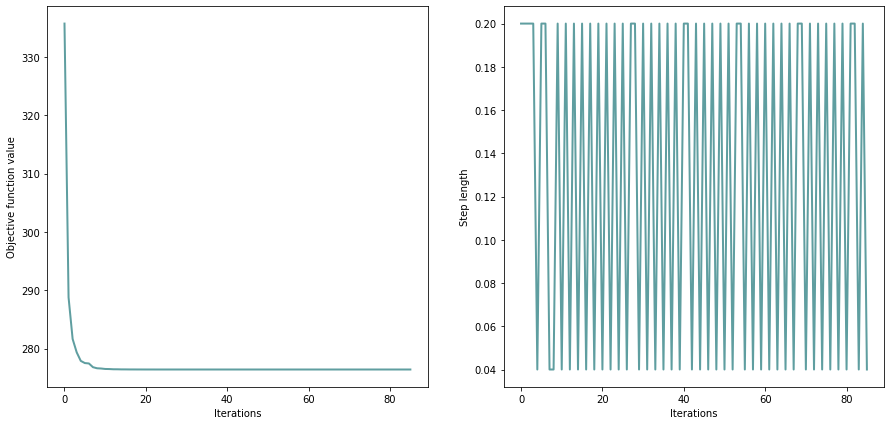

In [ ]:
from matplotlib.backend_bases import KeyEvent
# Print some results:
print('Execution time: ',ex_time_QN)
print('Function value at solution: ', func_val_QN)
print('Number of iterations: ', iter_QN)
print('Mean squared error for the sollution: ', err_QN,'\n')

# Plot

fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(15,7))

axs[0].plot([i for i in range(len(err_list_QN))],err_list_QN,color='cadetblue',linewidth=2)
axs[0].set_ylabel('Objective function value')
axs[0].set_xlabel('Iterations');

axs[1].plot([i for i in range(len(alpha_list_QN))],alpha_list_QN,color='cadetblue',linewidth=2)
axs[1].set_ylabel('Step length')
axs[1].set_xlabel('Iterations');

This method gives the worst results of all the three methods generated. Although an aproximation to the hessian is provided, about the same iterations of the gradient descent are used to converge.

Comparing the three methods, the Newton is the better to solve this problem. All the three methods gives the same results, giving same value of the objective function.

For the step length, it can be concluded that optimal values for $\alpha$ are around 0.04 and 0.20 for Quasi-Newton and gradient descent, while 1.00 is optimal for Newton.

## D. Algorithms for big data implementations

### D.1. Coordinate gradient descent

First, there is the need to ensamble a function which computes only partial derivatives of the error function, instead of the whole jacobian. This is the goal of the coordinate gradient.

$${\partial f}/{\partial \beta_{j}} = -2X_{j}^T(y-X\beta)+4\rho\beta_{j}^3$$

The function to calculate the partial derivative is computed below:

In [ ]:
def partial_derivative(betas_try, j, rho = rho, X = X, y = y):

  n = X.shape[0]
  par_der = -2/n*((X[:,j].T)@(y-X@betas_try)) + 4*rho*(betas_try[j]**3)

  return par_der

In [ ]:
# Definition of the gradient function:
def coordinate_gradient_desc(func, jacob, x0, maxiter, tolerance, s, beta, sigma):

  np.random.seed(1234)    # Setting the seed for reproducibility
  iter = 0
  past = x0+tolerance*1e6
  current = x0
  K = x0.size
  err_list = []
  alpha_list = []
  while math.sqrt(((current-past).T @ (current-past)))/K>tolerance and iter<=maxiter:
    iter += 1
    past = current

    # Selecting the aleatory component to optimize

    j = np.random.randint(low=0, high=K, size=None, dtype=int)                  # Random number between 0 and K-1
    p = np.zeros(K)
    p[j] = -partial_derivative(current,j,)                                      # The direction of the step is the gradient in the direction

    # Inducing the armijo rule to find alpha:
    alpha = s

    # The gradient in the armijo rule is replaced by the step (p = -partial derivative)
    # As calculating the whole gradient for this method is not the goal (which is reducing the operations)

    while error(current+alpha*p,rho,X,y) > error(current,rho,X,y) - sigma*alpha*p.T@p:
      alpha = alpha*beta
    alpha_list.append(alpha)

    # Once the alpha is sett, perform the descent:
    current = current + alpha*p
    err_list.append(error(current,rho,X,y))

  sol = current
  func_val = func(current,rho,X,y)
  return sol, func_val, iter, err_list, alpha_list

In [ ]:
# Implementation of the method:
tol = 1e-10
# Armijo inputs
s = 1
beta = 0.2
sigma = 1e-3

maxiter = 1e5
t1 = time()
sol_CGD, func_val_CGD, iter_CGD, err_list_CGD, alpha_list_CGD = coordinate_gradient_desc(error,jacob,beta0,maxiter,tol,s,beta,sigma)
t2 = time()

err_CGD = 1/K*((betas-sol_CGD).T)@(betas-sol_CGD)
ex_time_CGD = t2-t1

Execution time:  1.907499074935913
Function value at solution:  276.3971980819277
Number of iterations:  3500
Mean squared error for the sollution:  2.516092320786544 



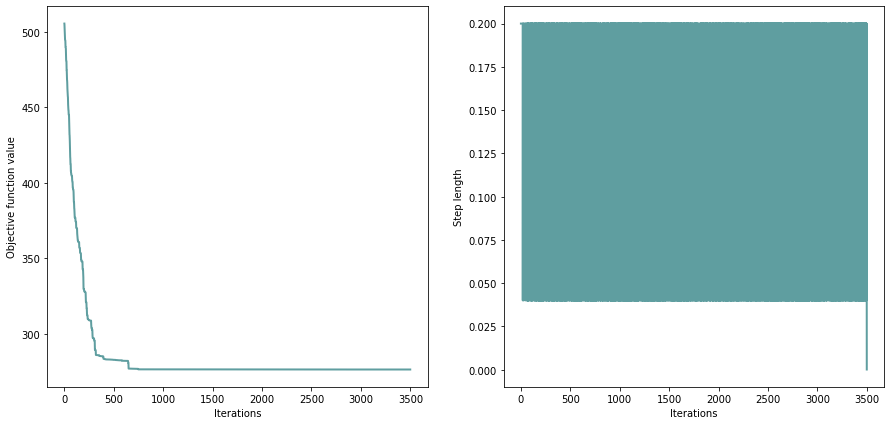

In [ ]:
# Print some results:
print('Execution time: ',ex_time_CGD)
print('Function value at solution: ', func_val_CGD)
print('Number of iterations: ', iter_CGD)
print('Mean squared error for the sollution: ', err_CGD,'\n')

# Plot
fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(15,7))

axs[0].plot([i for i in range(len(err_list_CGD))],err_list_CGD,color='cadetblue',linewidth=2)
axs[0].set_ylabel('Objective function value')
axs[0].set_xlabel('Iterations');

axs[1].plot([i for i in range(len(alpha_list_CGD))],alpha_list_CGD,color='cadetblue',linewidth=2)
axs[1].set_ylabel('Step length')
axs[1].set_xlabel('Iterations');

It is clear that this method has a problem with the last part of the convergence, as it randomly select the partial derivatives. Another fact that could be pointed out, is the large number of iterations used to converge (which is related with the previous point).

### D.2. Mini-batch gradient descent

In [ ]:
# Definition of the gradient function:
def minibatch_gradient_desc(func, jacob, x0, b, n, maxiter, tolerance, s, beta, sigma):

  # Now b is the size of the mini.batch sample size

  np.random.seed(12345)    # Setting the seed for reproducibility
  iter = 0
  past = x0+tolerance*1e6
  current = x0
  K = x0.size
  n = X.shape[0]
  err_list = []
  alpha_list = []
  A = np.column_stack((X, y))  # Concatenate observations and outcomes into the same matrix to shuffle later


  while math.sqrt(((current-past).T @ (current-past)))/K>tolerance and iter<=maxiter:
    iter += 1
    past = current

    # Selecting the aleatory rows to calculate jacobian and hessian
    np.random.shuffle(A)

    p = -jacob(current,rho,A[0:b,0:K],A[0:b,K])

    # Inducing the armijo rule to find alpha:
    alpha = s
    while error(current+alpha*p,rho,X,y) > error(current,rho,X,y) - sigma*alpha*p.T@p:
      alpha = alpha*beta
    alpha_list.append(alpha)
    # Once the alpha is sett, perform the descent:
    current = current + alpha*p
    err_list.append(error(current,rho,X,y))

  sol = current
  func_val = func(current,rho,X,y)
  return sol, func_val, iter, err_list, alpha_list

In [ ]:
# Implementation of the method:
tol = 1e-30
# Armijo inputs
s = 1
beta = 0.2
sigma = 1e-3

maxiter = 1e5
b = 200
n = X.shape[0]
t1 = time()
sol_MBGD, func_val_MBGD, iter_MBGD, err_list_MBGD, alpha_list_MBGD = minibatch_gradient_desc(error,jacob,beta0,b,n,maxiter,tol,s,beta,sigma)
t2 = time()

err_MBGD = 1/K*((betas-sol_MBGD).T)@(betas-sol_MBGD)
ex_time_MBGD = t2-t1

Execution time:  0.747969388961792
Function value at solution:  276.52435104983846
Number of iterations:  196
Mean squared error for the sollution:  2.5172656890105602 



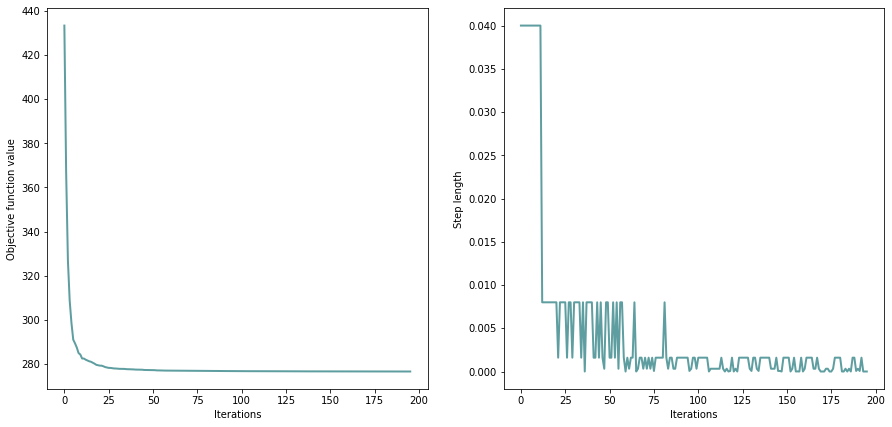

In [ ]:
# Print some results:
print('Execution time: ',ex_time_MBGD)
print('Function value at solution: ', func_val_MBGD)
print('Number of iterations: ', iter_MBGD)
print('Mean squared error for the sollution: ', err_MBGD,'\n')

# Plot
fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(15,7))

axs[0].plot([i for i in range(len(err_list_MBGD))],err_list_MBGD,color='cadetblue',linewidth=2)
axs[0].set_ylabel('Objective function value')
axs[0].set_xlabel('Iterations');

axs[1].plot([i for i in range(len(alpha_list_MBGD))],alpha_list_MBGD,color='cadetblue',linewidth=2)
axs[1].set_ylabel('Step length')
axs[1].set_xlabel('Iterations');

### D.3. Subsampled Hessian free inexact method

In [ ]:
# Definition of the gradient function:
def subhess_gradient_desc(func, jacob, x0, b_grad, b_hess, n, maxiter, tolerance, s, beta, sigma):

  # Now b is the size of the mini.batch sample size

  np.random.seed(12345)    # Setting the seed for reproducibility
  iter = 0
  past = x0+tolerance*1e6
  current = x0
  K = x0.size
  n = X.shape[0]
  err_list = []
  alpha_list = []
  A = np.column_stack((X, y))  # Concatenate observations and outcomes into the same matrix to shuffle later


  while math.sqrt(((current-past).T @ (current-past)))/K>tolerance and iter<=maxiter:
    iter += 1
    past = current

    # Selecting the aleatory rows to calculate jacobian and hessian
    np.random.shuffle(A)

    jac = jacob(current,rho,A[0:b_grad,0:K],A[0:b_grad,K])
    H = hess(current,rho,A[0:b_hess,0:K],A[0:b_hess,K])
    Hinv = np.linalg.inv(H)       # Inverting the KxK matrix
    p = - Hinv@jac      # Step direction for updating

    # Inducing the armijo rule to find alpha:
    alpha = s
    while error(current+alpha*p,rho,X,y) > error(current,rho,X,y) + sigma*alpha*p.T@jac:
      alpha = alpha*beta
    alpha_list.append(alpha)
    # Once the alpha is sett, perform the descent:
    current = current + alpha*p
    err_list.append(error(current,rho,X,y))

  sol = current
  func_val = func(current,rho,X,y)
  return sol, func_val, iter, err_list, alpha_list

In [ ]:
# Implementation of the method:
tol = 1e-30
# Armijo inputs
s = 1
beta = 0.2
sigma = 1e-5

maxiter = 1e5
b_grad = 100      # Number of rows to select from the X matrix for calculating the gradient
b_hess = 50       # Number of rows to select from the X matrix for calculating the hessian
n = X.shape[0]
t1 = time()
sol_SSH, func_val_SSH, iter_SSH, err_list_SSH, alpha_list_SSH = subhess_gradient_desc(error, jacob, beta0, b_grad, b_hess, n, maxiter, tol, s, beta, sigma)
t2 = time()

err_SSH = 1/K*((betas-sol_SSH).T)@(betas-sol_SSH)
ex_time_SSH = t2-t1

Execution time:  5.0383994579315186
Function value at solution:  276.68937219148035
Number of iterations:  759
Mean squared error for the sollution:  2.570532023267028 



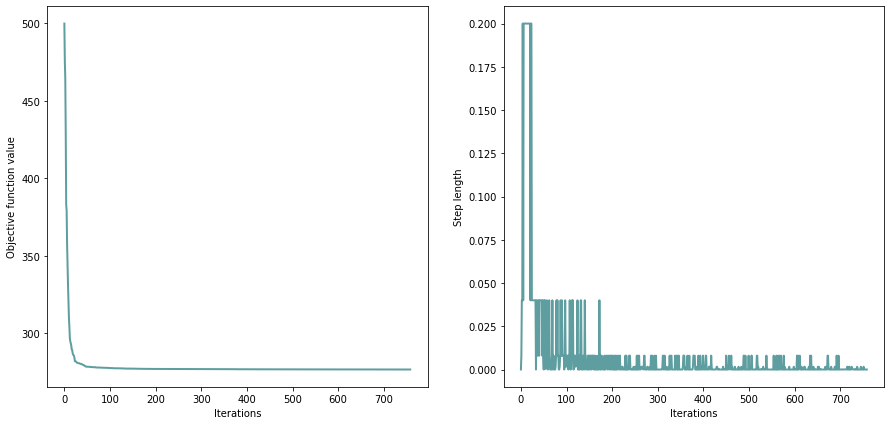

In [ ]:
# Print some results:
print('Execution time: ',ex_time_SSH)
print('Function value at solution: ', func_val_SSH)
print('Number of iterations: ', iter_SSH)
print('Mean squared error for the sollution: ', err_SSH,'\n')

# Plot
fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(15,7))

axs[0].plot([i for i in range(len(err_list_SSH))],err_list_SSH,color='cadetblue',linewidth=2)
axs[0].set_ylabel('Objective function value')
axs[0].set_xlabel('Iterations');

axs[1].plot([i for i in range(len(alpha_list_SSH))],alpha_list_SSH,color='cadetblue',linewidth=2)
axs[1].set_ylabel('Step length')
axs[1].set_xlabel('Iterations');

This methods give worse performance than the ones in section C. From the three methods above, SSH gives the worst result in terms of execution time. The reason below the low performance for those algorithms is the subsampling for calculating the jacobian and hessian. At each iteration a shuffling of the whole matrix has to be performed and this is time-consuming.

In therms of convergence, the coordinate gradient is converging into "jumps", and low tolerance has to be input to the function in order to work properly. Apart from that, the three methods gives similar insights into the convergence, with the Mini-Batch being the faster of all in that category.



## E. Constrained problem

In this section of the assignment, the problem to optimize is the following:

$$ min_\beta \frac{1}n (y - X\beta)^2 $$
$s.t$ $$\sum_{j=1}^{K} \beta_{j}^2 = 1$$

This constrained problem is the same as solving the following:

$$ min_{\beta} \frac{1}n (y - X\beta)^2 + \lambda\sum_{j=1}^{K} \beta_{j}^2 $$

For minimizing the above function, the following equation of the jacobian is presented:

$$\triangledown f = -\frac{2}nX^T(y - X\beta) + 2\lambda\beta = 0 $$

Obtaining the following solution for $\beta$:

$$\beta = \frac{1}n (X^TX-\lambda I)^{-1}X^Ty$$

$$\beta = f(\lambda)$$

Apart from the previous equation, the restriction has to be fulfiller also:

$$ \beta^T\beta = f(\lambda)^Tf(\lambda) - 1 = 0$$

In the end, is a matter of finding a sollution to that non-linear equation.  

1. Defining a function to solve $\beta = f(\lambda)$

In [ ]:
def fun(L,X,y):
  n = X.shape[0]
  K = X.shape[1]
  I = np.eye(K)
  M = X.T @ X - L*I
  Minv = np.linalg.inv(M)
  beta = 1/K*Minv @ X.T @ y

  error = beta.T@beta - 1

  return error

In [ ]:
def bet(L,X,y):
  n = X.shape[0]
  K = X.shape[1]
  I = np.eye(K)
  M = X.T @ X - L*I
  Minv = np.linalg.inv(M)
  beta = 1/K*Minv @ X.T @ y


  return beta

2. Solving the non-linear equation using the Bisection method. This method in particular split the unkown interval in half until is reaches the tolerance.

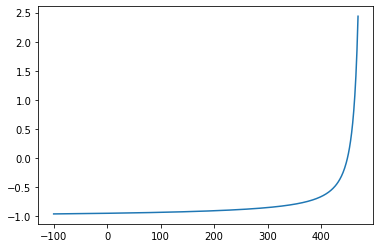

In [ ]:
# Print the function to have an initial guess:

L_list = [k for k in range(-100,470)]
norm_list = []
for L in L_list:

  norm = fun(L,X,y)
  norm_list.append(norm)

plt.plot(L_list,norm_list);

Lastly, the $\lambda$ which fulfill $\sum \beta_{j}^2 = 1$ is calculated.

In [ ]:
a = 400   # Number clearly below zero
b = 500   # Number clearly above zero

tol = 1e-3    # Tolerance for the langrange multiplier solution

while b-a>tol:
  c = (b+a)/2
  fc = fun(c,X,y)
  fa = fun(a,X,y)
  fb = fun(b,X,y)

  #Evaluate which one of those entries has the same sign (fa,fc or fb,fc):

  if fa*fc>0:
    a = c
  else:
    b = c

# c is the "lambda" lagrange multiplier which fulfill the constrain.
# Latter, c is input in the function beta=f(lambda) to obtain the beta solution

print('Lagrange multiplier: ',c)
fun(c,X,y)

solution = bet(c,X,y)

print('Solution for the shrinkage least squares problem:')
index = ['beta '+str(i) for i in range(1,K+1)]
data = pd.DataFrame(solution, index=index,columns=["Coefficents"])
data


Lagrange multiplier:  449.1325378417969
Solution for the shrinkage least squares problem:


,Coefficents
beta 1,0.036290
beta 2,-0.168709
beta 3,0.144186
beta 4,-0.040733
beta 5,0.160249
...,...
beta 96,0.017132
beta 97,-0.015219
beta 98,-0.078957
beta 99,-0.107626
